## COVID tracking

Basado en el estudio de https://github.com/therealcyberlord

Analisis de los datos de la expansión del último coronavirus (SARS-CoV-2) llamado por la OMS oficialmente COVID-19, un virus respiratorio altamente contagioso que apareció en Wuhan en Diciembre del 2019. 

- Data: https://github.com/CSSEGISandData/COVID-19 Repositorio propiedad de Johns Hopkins..
- Enlace al artículo sobre el COVID-19 en la OMS  https://www.who.int/emergencies/diseases/novel-coronavirus-2019
- Enlace al artículo en el CDC https://www.cdc.gov/coronavirus/2019-ncov
- visualización de los datos con ARCGIS https://gisanddata.maps.arcgis.com/apps/opsdashboard/index.html#/bda7594740fd40299423467b48e9ecf6

<img src='https://newsfortomorrow.com/wp-content/uploads/2020/01/1578562454_Wuhan-pneumonia-New-coronavirus-related-to-SARS-idenitified.jpg'>

In [81]:
import numpy as np 
import matplotlib.pyplot as plt 
import matplotlib.colors as mcolors
import matplotlib.dates as mdates 
import pandas as pd 
import random
import math
import time
from sklearn.linear_model import LinearRegression, BayesianRidge
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error
import datetime
import operator
plt.style.use('seaborn')
%matplotlib inline 

## Carga online de los datos
Los cargamos a partir del repositorio de Johns Hopkins en git

In [82]:
confirmed_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv')
recoveries_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Recovered.csv')
deaths_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Deaths.csv')

In [83]:
confirmed_df.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,3/5/20,3/6/20,3/7/20,3/8/20,3/9/20,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20
0,NaN,Thailand,15.0000,101.0000,2,3,5,7,8,8,...,47,48,50,50,50,53,59,70,75,82
1,NaN,Japan,36.0000,138.0000,2,1,2,2,4,4,...,360,420,461,502,511,581,639,639,701,773
2,NaN,Singapore,1.2833,103.8333,0,1,3,3,4,5,...,117,130,138,150,150,160,178,178,200,212
3,NaN,Nepal,28.1667,84.2500,0,0,0,1,1,1,...,1,1,1,1,1,1,1,1,1,1
4,NaN,Malaysia,2.5000,112.5000,0,0,0,3,4,4,...,50,83,93,99,117,129,149,149,197,238


### Gráfica con la evolución de contagios en España

In [84]:
# Me quedo con las fechas nada mas
cols = confirmed_df.columns
col_fechas_ind = cols[4:]

col_fechas_ind

Index(['1/22/20', '1/23/20', '1/24/20', '1/25/20', '1/26/20', '1/27/20',
       '1/28/20', '1/29/20', '1/30/20', '1/31/20', '2/1/20', '2/2/20',
       '2/3/20', '2/4/20', '2/5/20', '2/6/20', '2/7/20', '2/8/20', '2/9/20',
       '2/10/20', '2/11/20', '2/12/20', '2/13/20', '2/14/20', '2/15/20',
       '2/16/20', '2/17/20', '2/18/20', '2/19/20', '2/20/20', '2/21/20',
       '2/22/20', '2/23/20', '2/24/20', '2/25/20', '2/26/20', '2/27/20',
       '2/28/20', '2/29/20', '3/1/20', '3/2/20', '3/3/20', '3/4/20', '3/5/20',
       '3/6/20', '3/7/20', '3/8/20', '3/9/20', '3/10/20', '3/11/20', '3/12/20',
       '3/13/20', '3/14/20'],
      dtype='object')

In [85]:
x_values = [datetime.datetime.strptime(d,"%m/%d/%y").date() for d in col_fechas_ind.values]

In [95]:
# chequeo españa
esp_confirmed = confirmed_df[confirmed_df["Country/Region"]=="Spain"].loc[:, col_fechas_ind]
y_values = esp_confirmed.values[0]
y_values

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    1,
          1,    1,    1,    1,    1,    1,    1,    2,    2,    2,    2,
          2,    2,    2,    2,    2,    2,    2,    2,    2,    2,    2,
          2,    6,   13,   15,   32,   45,   84,  120,  165,  222,  259,
        400,  500,  673, 1073, 1695, 2277, 2277, 5232, 6391], dtype=int64)

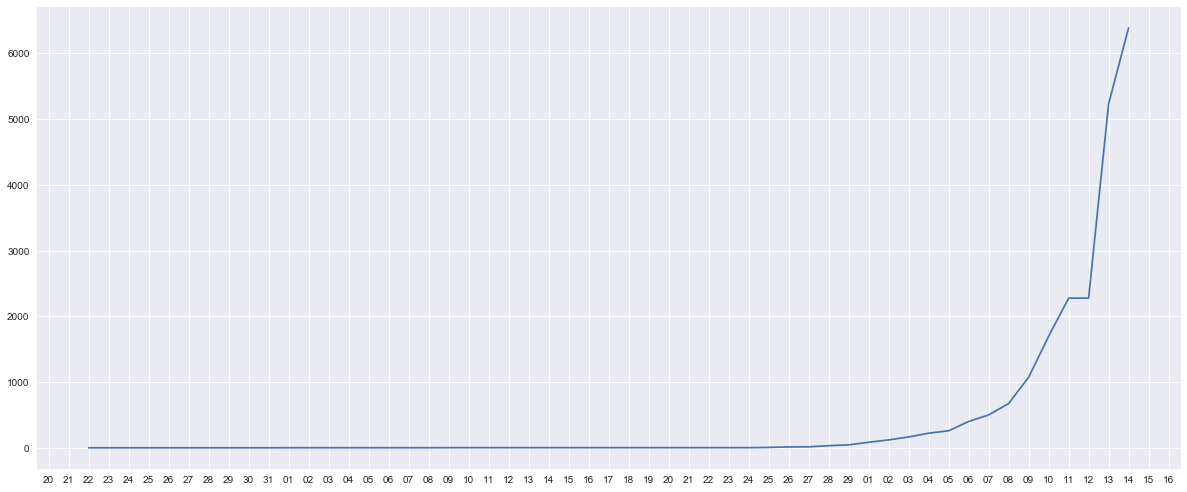

In [96]:
#preparo gráfica, me cojo sus ejes
ax = plt.gca()

#defino el eje x como de fechas
formatter = mdates.DateFormatter("%d")
ax.xaxis.set_major_formatter(formatter)

locator = mdates.DayLocator()
ax.xaxis.set_major_locator(locator)

# pinto mis dos arrays
plt.plot(x_values, y_values)

# ajusto a posteriori su tamaño
fig = plt.gcf()
fig.set_size_inches(20.5, 8.5)


## Estudio global

Me quedo con los datos numéricos nada más, asi que cojo solo las col_fechas_ind.

In [88]:
confirmed = confirmed_df.loc[:, col_fechas_ind]
deaths = deaths_df.loc[:, col_fechas_ind]
recoveries = recoveries_df.loc[:, col_fechas_ind]

Creamos dataframes con todo

In [109]:
world_cases = []
total_deaths = [] 
mortality_rate = []
total_recovered = [] 

# totalizamos en un array los resultados
for i in col_fechas_ind:
    confirmed_sum = confirmed[i].sum()
    death_sum = deaths[i].sum()
    recovered_sum = recoveries[i].sum()
    world_cases.append(confirmed_sum)
    total_deaths.append(death_sum)
    mortality_rate.append(death_sum/confirmed_sum)
    total_recovered.append(recovered_sum)


In [111]:
# pasamos el array a un array de numpy (array de arrays de longitud 1)
dias_desde_1_22 = np.array([i for i in range(len(col_fechas_ind))]).reshape(-1, 1)
world_cases = np.array(world_cases).reshape(-1, 1)
total_deaths = np.array(total_deaths).reshape(-1, 1)
total_recovered = np.array(total_recovered).reshape(-1, 1)

## Preparamos las predicciones

en el eje x queremos fechas desde el principio hasta 5 dias en el futuro

In [114]:
days_in_future = 5
future_forcast = np.array([i for i in range(len(col_fechas_ind)+days_in_future)]).reshape(-1, 1)
adjusted_dates = future_forcast[:-5]

# en lugar de unas columnas numeradas del 1 al 58 lo pasamos a datetime para verlo mejor

start = '1/22/20'
start_date = datetime.datetime.strptime(start, '%m/%d/%y')
future_forcast_dates = []
for i in range(len(future_forcast)):
    future_forcast_dates.append((start_date + datetime.timedelta(days=i)).strftime('%m/%d/%y'))



In [123]:
X_train_confirmed, X_test_confirmed, y_train_confirmed, y_test_confirmed = train_test_split(days_since_1_22, world_cases, test_size=0.3, shuffle=False) 

Model for predicting # of confirmed cases. I am using support vector machine, bayesian ridge , and linear regression in this example. 

In [124]:
kernel = ['linear', 'poly', 'sigmoid', 'rbf']
c = [0.01, 0.1, 1, 10]
gamma = [0.01, 0.1, 1]
epsilon = [0.01, 0.1, 1]
shrinking = [True, False]
svm_grid = {'kernel': kernel, 'C': c, 'gamma' : gamma, 'epsilon': epsilon, 'shrinking' : shrinking}

svm = SVR()
svm_search = RandomizedSearchCV(svm, svm_grid, scoring='neg_mean_squared_error', cv=3, return_train_score=True, n_jobs=-1, n_iter=40, verbose=1)
svm_search.fit(X_train_confirmed, y_train_confirmed)

Fitting 3 folds for each of 40 candidates, totalling 120 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    1.7s finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3,
                                 epsilon=0.1, gamma='scale', kernel='rbf',
                                 max_iter=-1, shrinking=True, tol=0.001,
                                 verbose=False),
                   iid='deprecated', n_iter=40, n_jobs=-1,
                   param_distributions={'C': [0.01, 0.1, 1, 10],
                                        'epsilon': [0.01, 0.1, 1],
                                        'gamma': [0.01, 0.1, 1],
                                        'kernel': ['linear', 'poly', 'sigmoid',
                                                   'rbf'],
                                        'shrinking': [True, False]},
                   pre_dispatch='2*n_jobs', random_state=None, refit=True,
                   return_train_score=True, scoring='neg_mean_squared_error',
                   verbose=1)

In [125]:
svm_search.best_params_

{'shrinking': False, 'kernel': 'linear', 'gamma': 0.1, 'epsilon': 1, 'C': 10}

In [126]:
svm_confirmed = svm_search.best_estimator_
svm_pred = svm_confirmed.predict(future_forcast)

Mean Absolute Error (MAE): 7196.125
Mean Squared Error (MSE): 149167958.25


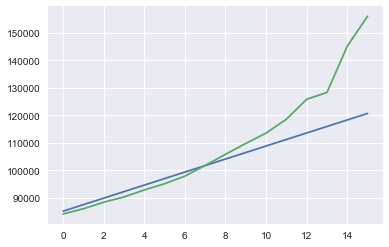

In [128]:
# check against testing data
svm_test_pred = svm_confirmed.predict(X_test_confirmed)
plt.plot(svm_test_pred)
plt.plot(y_test_confirmed)
print('Mean Absolute Error (MAE):', mean_absolute_error(svm_test_pred, y_test_confirmed))
print('Mean Squared Error (MSE):',mean_squared_error(svm_test_pred, y_test_confirmed))

In [129]:
linear_model = LinearRegression(normalize=True, fit_intercept=True)
linear_model.fit(X_train_confirmed, y_train_confirmed)
test_linear_pred = linear_model.predict(X_test_confirmed)
linear_pred = linear_model.predict(future_forcast)
print('MAE:', mean_absolute_error(test_linear_pred, y_test_confirmed))
print('MSE:',mean_squared_error(test_linear_pred, y_test_confirmed))

MAE: 10954.303461356078
MSE: 135539920.09788415


In [130]:
print(linear_model.coef_)
print(linear_model.intercept_)

[[2802.88999526]]
[-8823.29018492]


In [131]:
tol = [1e-4, 1e-3, 1e-2]
alpha_1 = [1e-7, 1e-6, 1e-5, 1e-4]
alpha_2 = [1e-7, 1e-6, 1e-5, 1e-4]
lambda_1 = [1e-7, 1e-6, 1e-5, 1e-4]
lambda_2 = [1e-7, 1e-6, 1e-5, 1e-4]

bayesian_grid = {'tol': tol, 'alpha_1': alpha_1, 'alpha_2' : alpha_2, 'lambda_1': lambda_1, 'lambda_2' : lambda_2}

bayesian = BayesianRidge()
bayesian_search = RandomizedSearchCV(bayesian, bayesian_grid, scoring='neg_mean_squared_error', cv=3, return_train_score=True, n_jobs=-1, n_iter=40, verbose=1)
bayesian_search.fit(X_train_confirmed, y_train_confirmed)

Fitting 3 folds for each of 40 candidates, totalling 120 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    0.0s finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=BayesianRidge(alpha_1=1e-06, alpha_2=1e-06,
                                           alpha_init=None, compute_score=False,
                                           copy_X=True, fit_intercept=True,
                                           lambda_1=1e-06, lambda_2=1e-06,
                                           lambda_init=None, n_iter=300,
                                           normalize=False, tol=0.001,
                                           verbose=False),
                   iid='deprecated', n_iter=40, n_jobs=-1,
                   param_distributions={'alpha_1': [1e-07, 1e-06, 1e-05,
                                                    0.0001],
                                        'alpha_2': [1e-07, 1e-06, 1e-05,
                                                    0.0001],
                                        'lambda_1': [1e-07, 1e-06, 1e-05,
                                                 

In [132]:
bayesian_confirmed = bayesian_search.best_estimator_
test_bayesian_pred = bayesian_confirmed.predict(X_test_confirmed)
bayesian_pred = bayesian_confirmed.predict(future_forcast)
print('MAE:', mean_absolute_error(test_bayesian_pred, y_test_confirmed))
print('MSE:',mean_squared_error(test_bayesian_pred, y_test_confirmed))

MAE: 10901.792994722155
MSE: 134628277.4101073


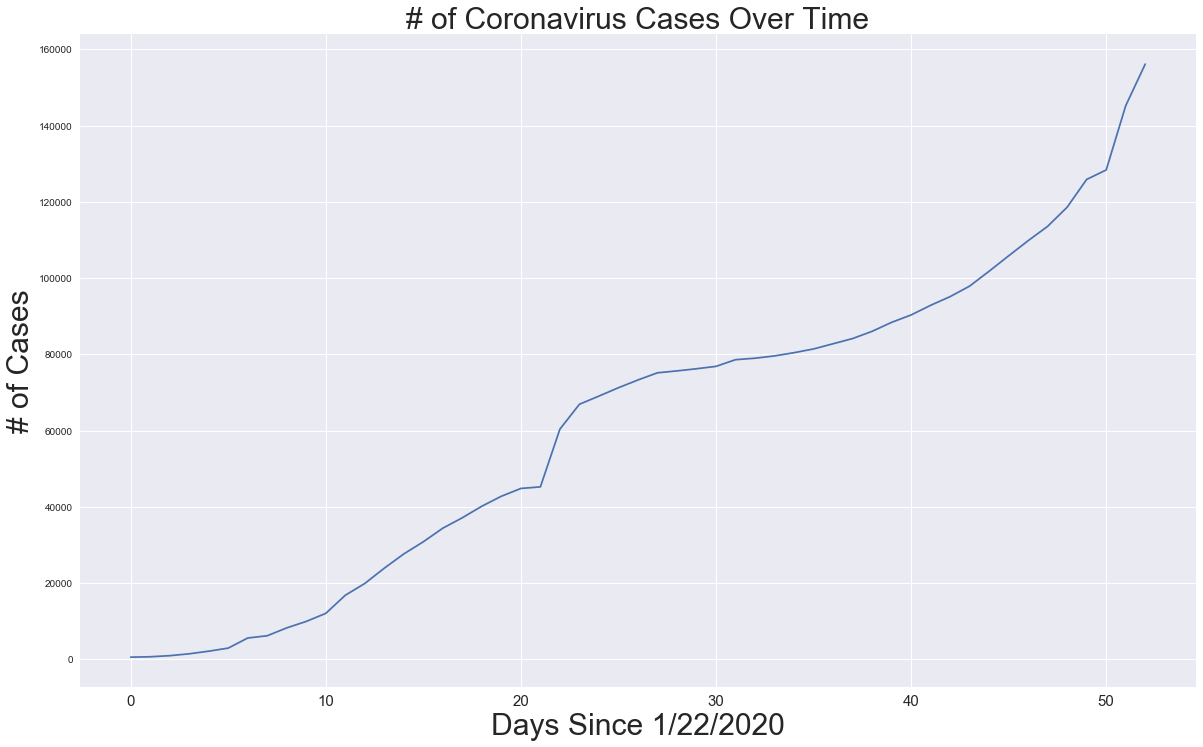

In [135]:
plt.figure(figsize=(20, 12))
plt.plot(adjusted_dates, world_cases)
plt.title('# of Coronavirus Cases Over Time', size=30)
plt.xlabel('Days Since 1/22/2020', size=30)
plt.ylabel('# of Cases', size=30)
plt.xticks(size=15)
plt.show()

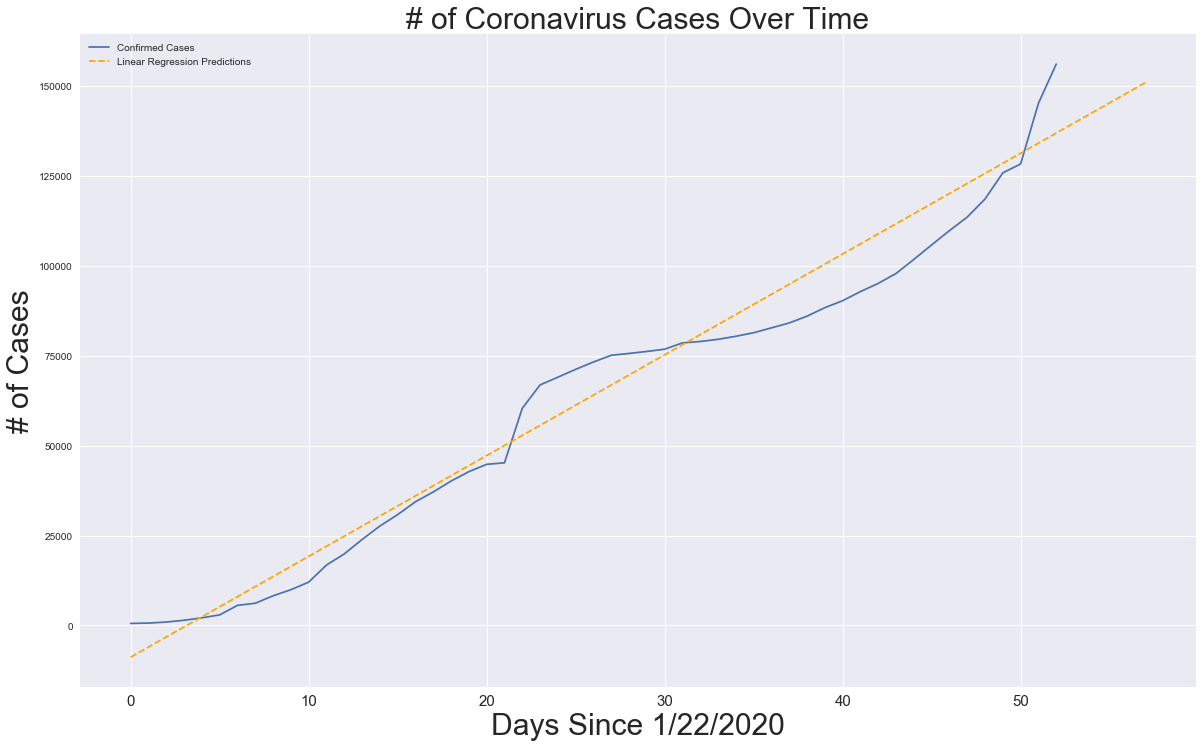

In [136]:
plt.figure(figsize=(20, 12))
plt.plot(adjusted_dates, world_cases)
plt.plot(future_forcast, linear_pred, linestyle='dashed', color='orange')
plt.title('# of Coronavirus Cases Over Time', size=30)
plt.xlabel('Days Since 1/22/2020', size=30)
plt.ylabel('# of Cases', size=30)
plt.legend(['Confirmed Cases', 'Linear Regression Predictions'])
plt.xticks(size=15)
plt.show()

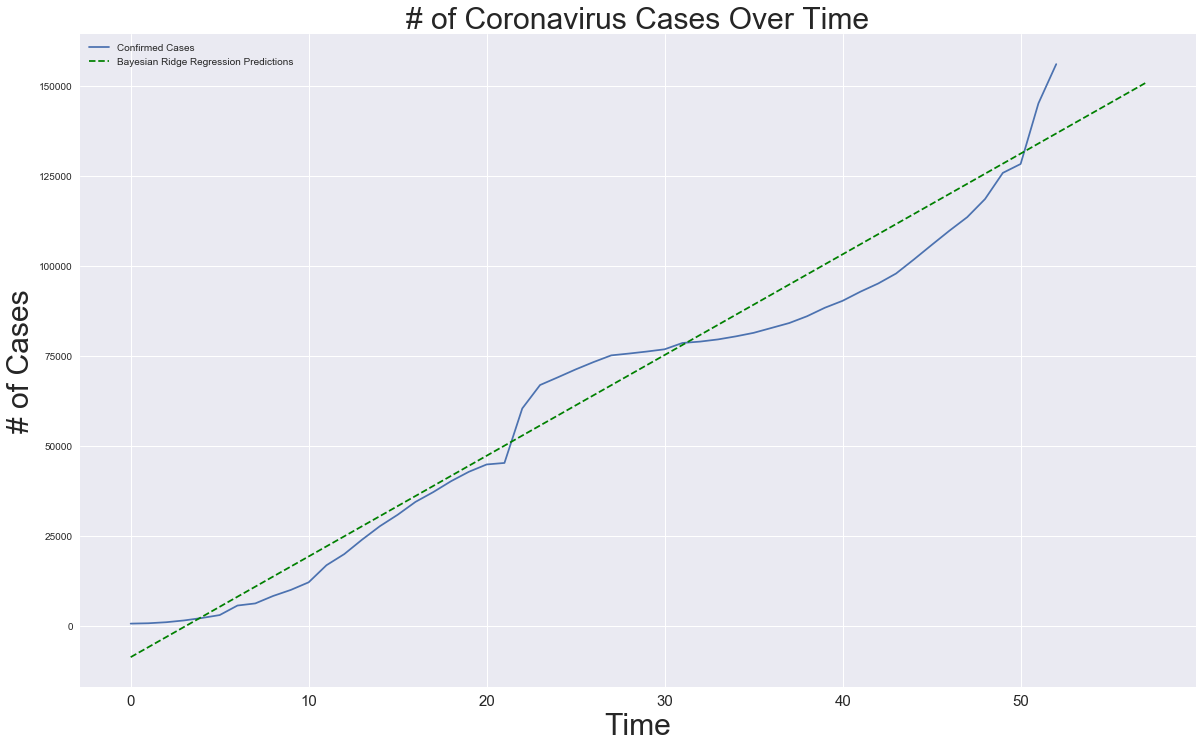

In [137]:
plt.figure(figsize=(20, 12))
plt.plot(adjusted_dates, world_cases)
plt.plot(future_forcast, bayesian_pred, linestyle='dashed', color='green')
plt.title('# of Coronavirus Cases Over Time', size=30)
plt.xlabel('Time', size=30)
plt.ylabel('# of Cases', size=30)
plt.legend(['Confirmed Cases', 'Bayesian Ridge Regression Predictions'])
plt.xticks(size=15)
plt.show()

In [138]:
# Future predictions using SVM 
print('SVM future predictions:')
set(zip(future_forcast_dates[-5:], svm_pred[-5:]))

SVM future predictions:


{('03/15/20', 123079.0),
 ('03/16/20', 125451.0),
 ('03/17/20', 127823.0),
 ('03/18/20', 130195.0),
 ('03/19/20', 132567.0)}

In [139]:
# Future predictions using Linear Regression 
print('Ridge regression future predictions:')
set(zip(future_forcast_dates[-5:], bayesian_pred[-5:]))

Ridge regression future predictions:


{('03/15/20', 139628.4800419984),
 ('03/16/20', 142428.47290806324),
 ('03/17/20', 145228.46577412807),
 ('03/18/20', 148028.45864019287),
 ('03/19/20', 150828.4515062577)}

In [142]:
# Future predictions using Linear Regression 
print('Linear regression future predictions:')
print(linear_pred[-5:])

Linear regression future predictions:
[[139729.87956377]
 [142532.76955903]
 [145335.65955429]
 [148138.54954955]
 [150941.43954481]]


Graphing the number of confirmed cases, deaths, and the mortality rate over time, as well as the number of recoveries

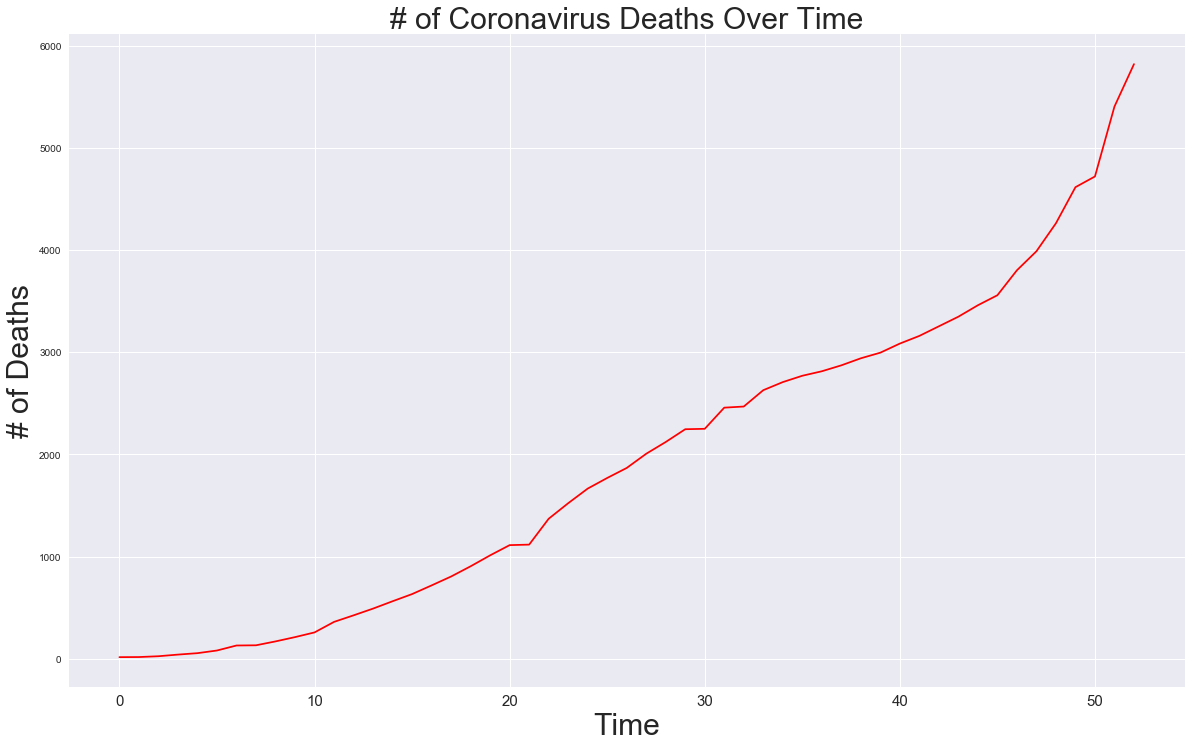

In [143]:
plt.figure(figsize=(20, 12))
plt.plot(adjusted_dates, total_deaths, color='red')
plt.title('# of Coronavirus Deaths Over Time', size=30)
plt.xlabel('Time', size=30)
plt.ylabel('# of Deaths', size=30)
plt.xticks(size=15)
plt.show()

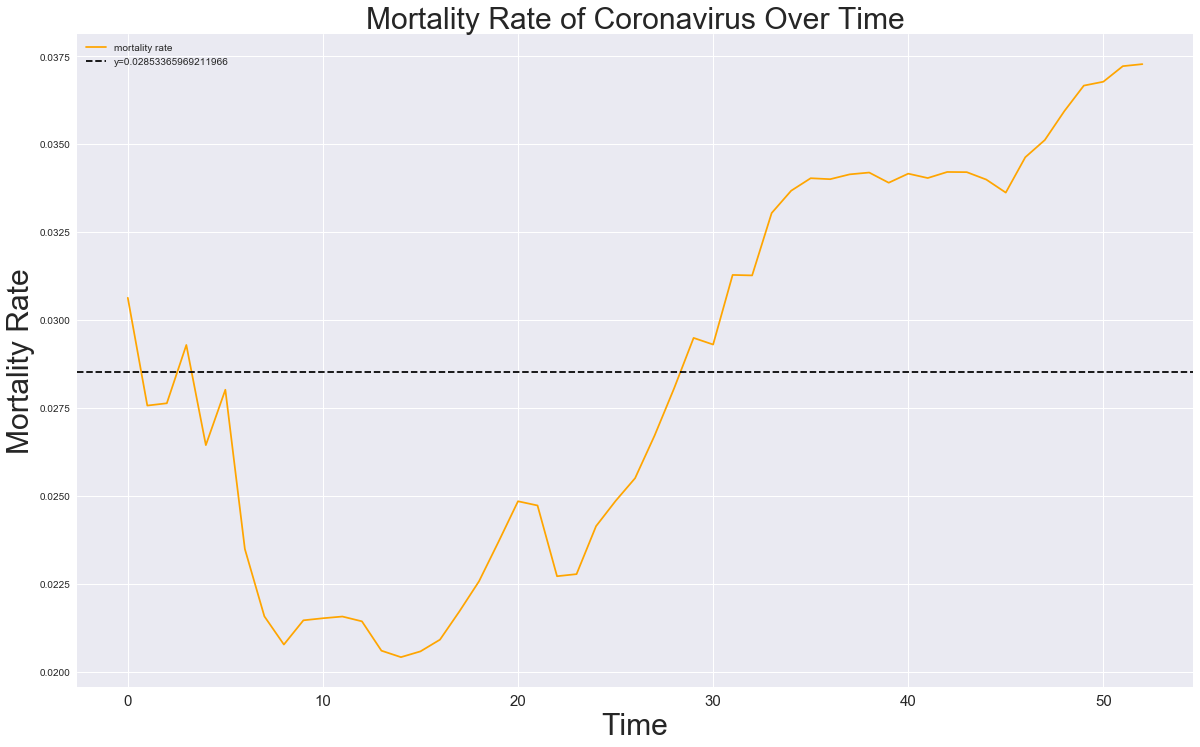

In [144]:
mean_mortality_rate = np.mean(mortality_rate)
plt.figure(figsize=(20, 12))
plt.plot(adjusted_dates, mortality_rate, color='orange')
plt.axhline(y = mean_mortality_rate,linestyle='--', color='black')
plt.title('Mortality Rate of Coronavirus Over Time', size=30)
plt.legend(['mortality rate', 'y='+str(mean_mortality_rate)])
plt.xlabel('Time', size=30)
plt.ylabel('Mortality Rate', size=30)
plt.xticks(size=15)
plt.show()

Graphing the number of deaths and the number of recoveries

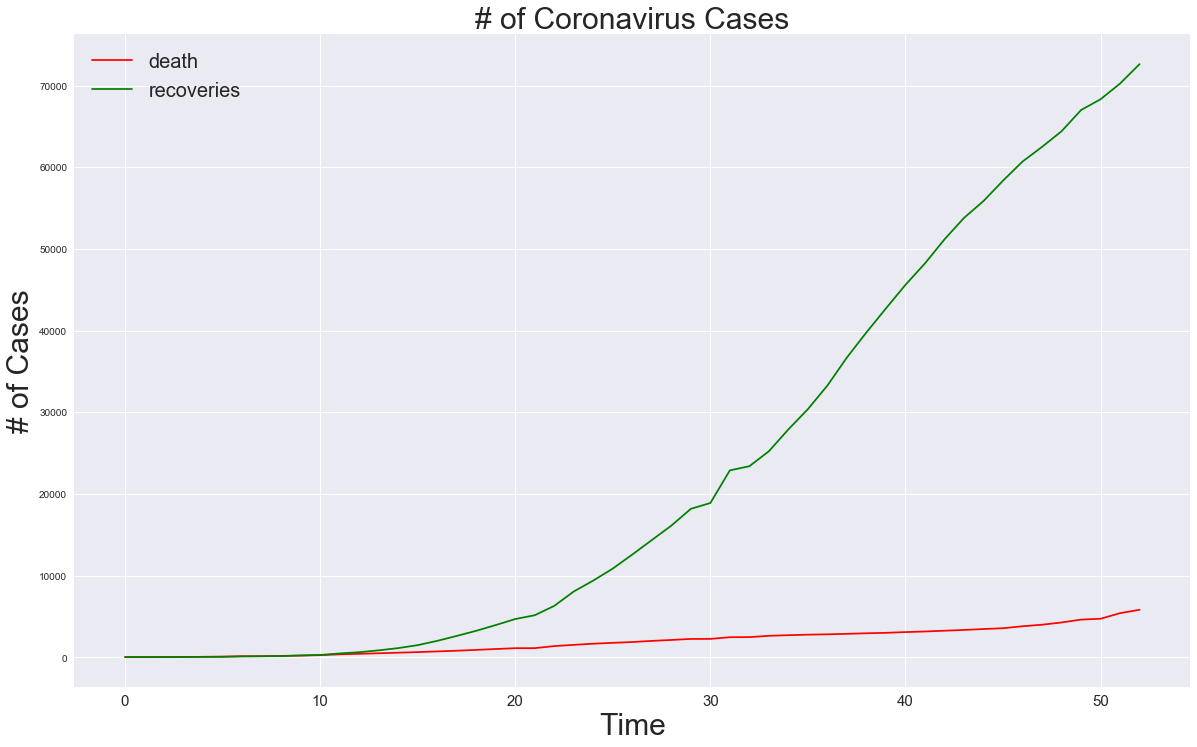

In [146]:
plt.figure(figsize=(20, 12))
plt.plot(adjusted_dates, total_deaths, color='r')
plt.plot(adjusted_dates, total_recovered, color='green')
plt.legend(['death', 'recoveries'], loc='best', fontsize=20)
plt.title('# of Coronavirus Cases', size=30)
plt.xlabel('Time', size=30)
plt.ylabel('# of Cases', size=30)
plt.xticks(size=15)
plt.show()





Plotting deaths vs recoveries

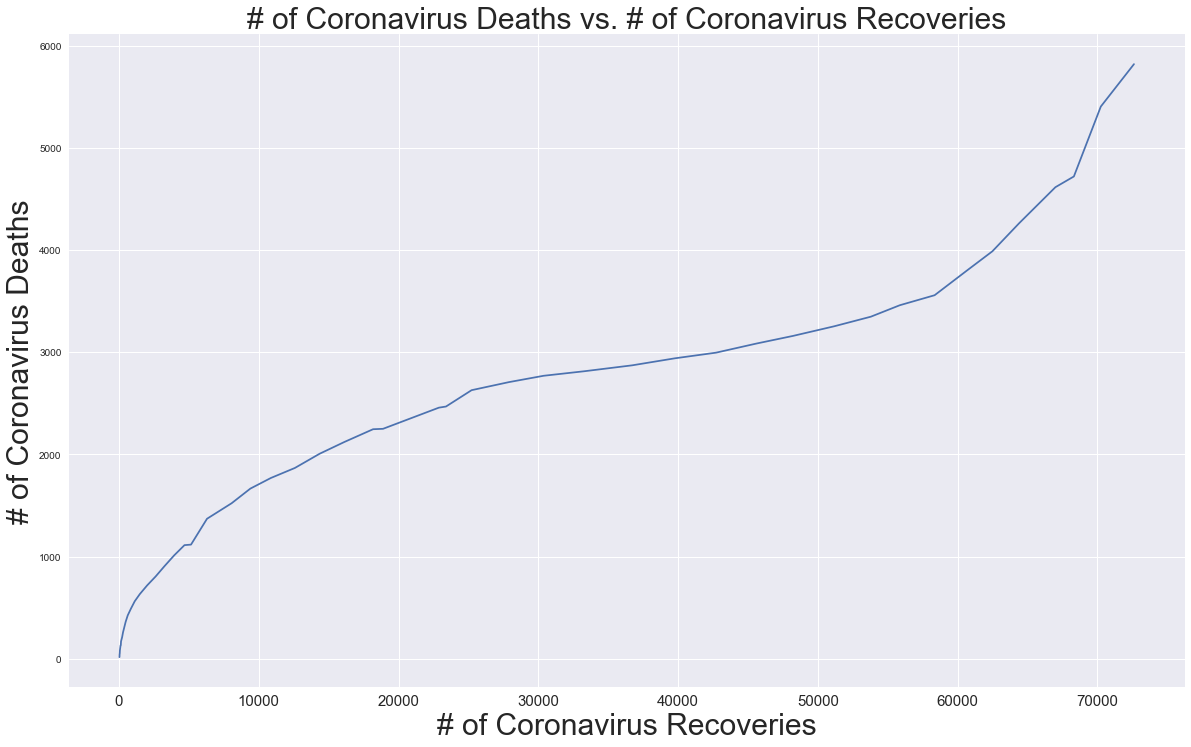

In [148]:
plt.figure(figsize=(20, 12))
plt.plot(total_recovered, total_deaths)
plt.title('# of Coronavirus Deaths vs. # of Coronavirus Recoveries', size=30)
plt.xlabel('# of Coronavirus Recoveries', size=30)
plt.ylabel('# of Coronavirus Deaths', size=30)
plt.xticks(size=15)
plt.show()

In [184]:
latest_confirmed = confirmed_df[col_fechas_ind[-1]]
latest_deaths = deaths_df[col_fechas_ind[-1]]
latest_recoveries = recoveries_df[col_fechas_ind[-1]]

Getting information about countries/regions that have confirmed coronavirus cases

In [185]:
unique_countries =  list(confirmed_df['Country/Region'].unique())

In [152]:
country_confirmed_cases = []
no_cases = []
for i in unique_countries:
    cases = latest_confirmed[confirmed_df['Country/Region']==i].sum()
    if cases > 0:
        country_confirmed_cases.append(cases)
    else:
        no_cases.append(i)
        
for i in no_cases:
    unique_countries.remove(i)
    
unique_countries = [k for k, v in sorted(zip(unique_countries, country_confirmed_cases), key=operator.itemgetter(1), reverse=True)]
for i in range(len(unique_countries)):
    country_confirmed_cases[i] = latest_confirmed[confirmed_df['Country/Region']==unique_countries[i]].sum()

In [153]:
# number of cases per country/region
print('Confirmed Cases by Countries/Regions:')
for i in range(len(unique_countries)):
    print(f'{unique_countries[i]}: {country_confirmed_cases[i]} cases')

Confirmed Cases by Countries/Regions:
China: 80977 cases
Italy: 21157 cases
Iran: 12729 cases
Korea, South: 8086 cases
Spain: 6391 cases
Germany: 4585 cases
France: 4480 cases
US: 2727 cases
Switzerland: 1359 cases
United Kingdom: 1143 cases
Norway: 1090 cases
Sweden: 961 cases
Netherlands: 959 cases
Denmark: 836 cases
Japan: 773 cases
Cruise Ship: 696 cases
Belgium: 689 cases
Austria: 655 cases
Qatar: 337 cases
Australia: 250 cases
Malaysia: 238 cases
Greece: 228 cases
Finland: 225 cases
Singapore: 212 cases
Bahrain: 210 cases
Canada: 198 cases
Israel: 193 cases
Czechia: 189 cases
Slovenia: 181 cases
Portugal: 169 cases
Iceland: 156 cases
Brazil: 151 cases
Ireland: 129 cases
Romania: 123 cases
Estonia: 115 cases
Philippines: 111 cases
Iraq: 110 cases
Egypt: 109 cases
Kuwait: 104 cases
Saudi Arabia: 103 cases
Poland: 103 cases
India: 102 cases
Indonesia: 96 cases
Lebanon: 93 cases
United Arab Emirates: 85 cases
Thailand: 82 cases
San Marino: 80 cases
Chile: 61 cases
Russia: 59 cases
Ta

In [154]:
unique_provinces =  list(confirmed_df['Province/State'].unique())
# those are countries, which are not provinces/states.
outliers = ['United Kingdom', 'Denmark', 'France']
for i in outliers:
    unique_provinces.remove(i)

Getting the latest information about provinces/states that have confirmed coronavirus cases

In [155]:
province_confirmed_cases = []
no_cases = [] 
for i in unique_provinces:
    cases = latest_confirmed[confirmed_df['Province/State']==i].sum()
    if cases > 0:
        province_confirmed_cases.append(cases)
    else:
        no_cases.append(i)
 
# remove areas with no confirmed cases
for i in no_cases:
    unique_provinces.remove(i)
    
unique_provinces = [k for k, v in sorted(zip(unique_provinces, province_confirmed_cases), key=operator.itemgetter(1), reverse=True)]
for i in range(len(unique_provinces)):
    province_confirmed_cases[i] = latest_confirmed[confirmed_df['Province/State']==unique_provinces[i]].sum()

In [156]:
# number of cases per province/state/city
print('Confirmed Cases by Province/States (US, China, Australia, Canada):')
for i in range(len(unique_provinces)):
    print(f'{unique_provinces[i]}: {province_confirmed_cases[i]} cases')

Confirmed Cases by Province/States (US, China, Australia, Canada):
Hubei: 67790 cases
Guangdong: 1356 cases
Henan: 1273 cases
Zhejiang: 1227 cases
Hunan: 1018 cases
Anhui: 990 cases
Jiangxi: 935 cases
Shandong: 760 cases
Diamond Princess: 742 cases
Jiangsu: 631 cases
Chongqing: 576 cases
Washington: 572 cases
Sichuan: 539 cases
New York: 525 cases
Heilongjiang: 482 cases
Beijing: 437 cases
Shanghai: 353 cases
California: 340 cases
Hebei: 318 cases
Fujian: 296 cases
Guangxi: 252 cases
Shaanxi: 245 cases
Yunnan: 174 cases
Hainan: 168 cases
Guizhou: 146 cases
Hong Kong: 140 cases
Massachusetts: 138 cases
Tianjin: 136 cases
Shanxi: 133 cases
Gansu: 129 cases
Liaoning: 125 cases
New South Wales: 112 cases
Colorado: 101 cases
Jilin: 93 cases
Ontario: 79 cases
Louisiana: 77 cases
Florida: 76 cases
Xinjiang: 76 cases
Inner Mongolia: 75 cases
Ningxia: 75 cases
New Jersey: 69 cases
Georgia: 66 cases
British Columbia: 64 cases
Illinois: 64 cases
Texas: 57 cases
Victoria: 49 cases
Pennsylvania: 47

In [157]:
nan_indices = [] 

# handle nan if there is any, it is usually a float: float('nan')

for i in range(len(unique_provinces)):
    if type(unique_provinces[i]) == float:
        nan_indices.append(i)

unique_provinces = list(unique_provinces)
province_confirmed_cases = list(province_confirmed_cases)

for i in nan_indices:
    unique_provinces.pop(i)
    province_confirmed_cases.pop(i)

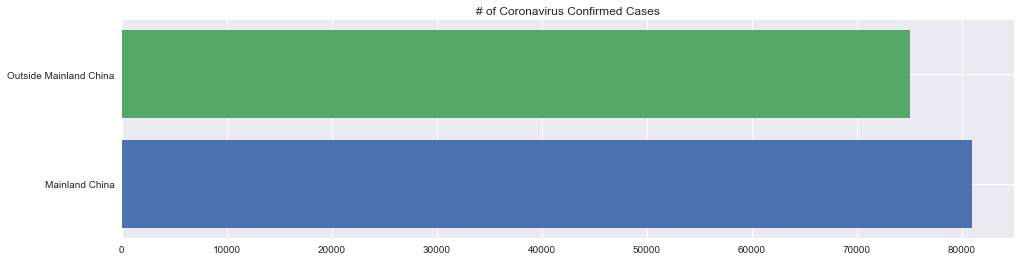

In [164]:
china_confirmed = latest_confirmed[confirmed_df['Country/Region']=='China'].sum()
outside_mainland_china_confirmed = np.sum(country_confirmed_cases) - china_confirmed
plt.figure(figsize=(16, 4))
plt.barh('Mainland China', china_confirmed)
plt.barh('Outside Mainland China', outside_mainland_china_confirmed)
plt.title('# of Coronavirus Confirmed Cases')
plt.show()


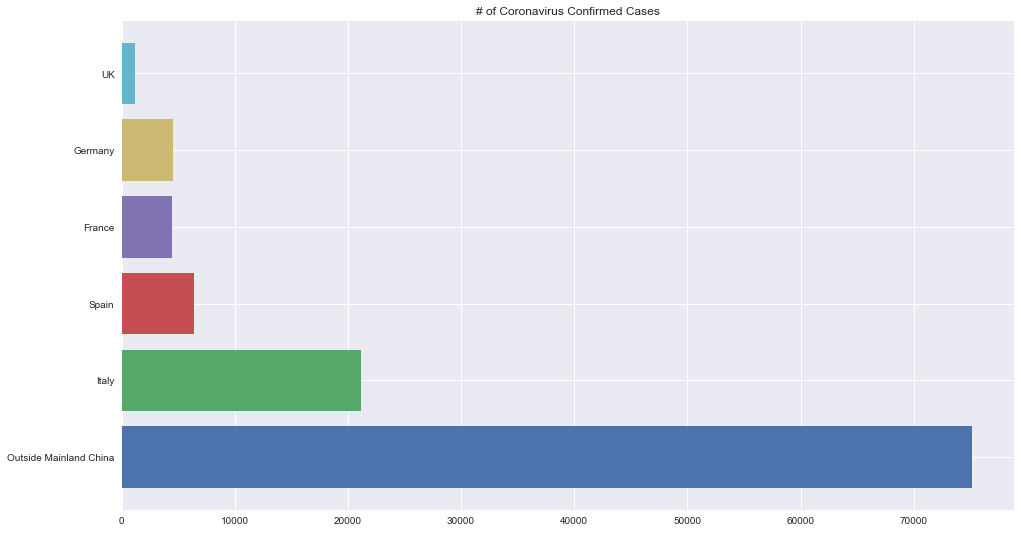

In [166]:
outside_mainland_china_confirmed = np.sum(country_confirmed_cases) - china_confirmed
spain_confirmed = latest_confirmed[confirmed_df['Country/Region']=='Spain'].sum()
italy_confirmed = latest_confirmed[confirmed_df['Country/Region']=='Italy'].sum()
germany_confirmed = latest_confirmed[confirmed_df['Country/Region']=='Germany'].sum()
france_confirmed = latest_confirmed[confirmed_df['Country/Region']=='France'].sum()
united_kingdom_confirmed = latest_confirmed[confirmed_df['Country/Region']=='United Kingdom'].sum()
plt.figure(figsize=(16, 9))
plt.barh('Outside Mainland China', outside_mainland_china_confirmed)
plt.barh('Italy', italy_confirmed)
plt.barh('Spain', spain_confirmed)
plt.barh('France', france_confirmed)
plt.barh('Germany', germany_confirmed)
plt.barh('UK',united_kingdom_confirmed)
plt.title('# of Coronavirus Confirmed Cases')
plt.show()

In [171]:

print('Mainland China: {} cases'.format(china_confirmed))
print('Outside Mainland China: {} cases, of wich:'.format(outside_mainland_china_confirmed))
print('   -Italy: {} cases'.format(italy_confirmed))
print('   -Spain: {} cases'.format(spain_confirmed))
print('   -France: {} cases'.format(france_confirmed))
print('   -Germany: {} cases'.format(germany_confirmed))
print('   -UK: {} cases'.format(united_kingdom_confirmed))

Mainland China: 80977 cases
Outside Mainland China: 75125 cases, of wich:
   -Italy: 21157 cases
   -Spain: 6391 cases
   -France: 4480 cases
   -Germany: 4585 cases
   -UK: 1143 cases


Visual Representations (bar charts and pie charts)

In [167]:
# Only show 10 countries with the most confirmed cases, the rest are grouped into the other category
visual_unique_countries = [] 
visual_confirmed_cases = []
others = np.sum(country_confirmed_cases[10:])
for i in range(len(country_confirmed_cases[:10])):
    visual_unique_countries.append(unique_countries[i])
    visual_confirmed_cases.append(country_confirmed_cases[i])

visual_unique_countries.append('Others')
visual_confirmed_cases.append(others)

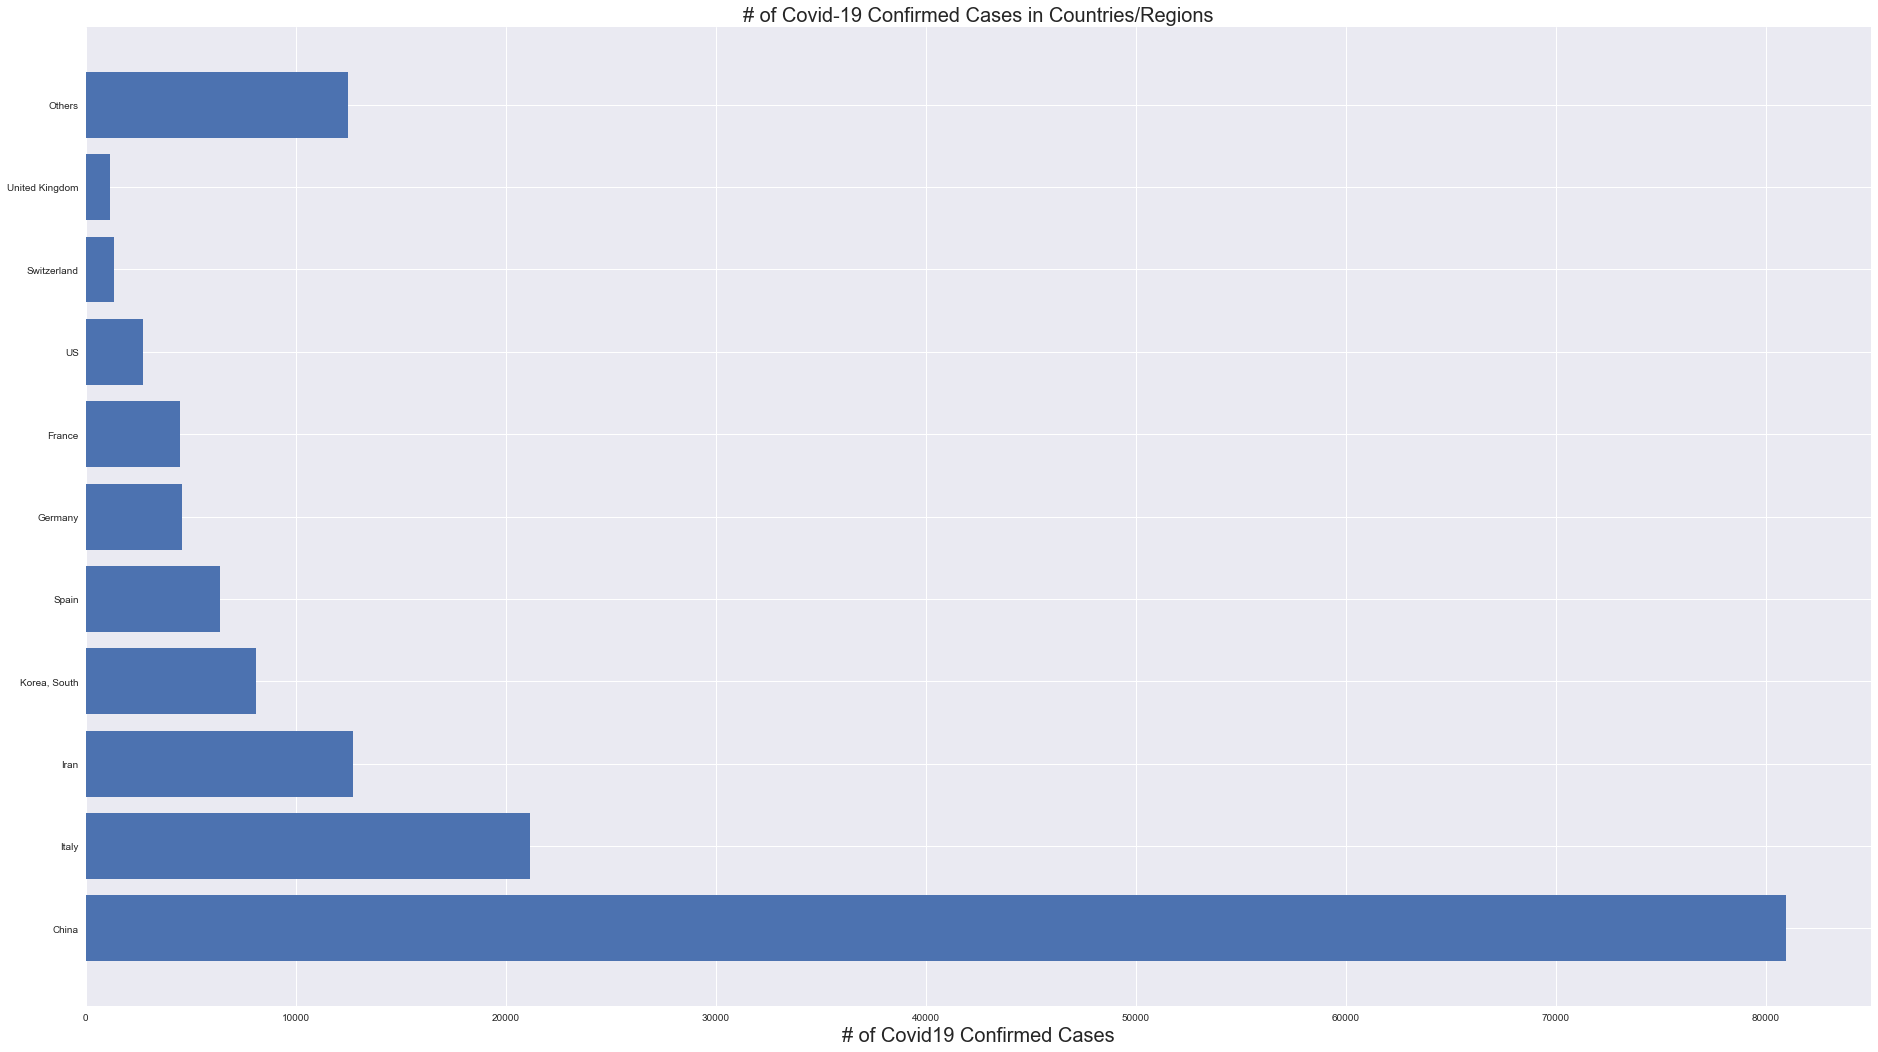

In [172]:
plt.figure(figsize=(32, 18))
plt.barh(visual_unique_countries, visual_confirmed_cases)
plt.title('# of Covid-19 Confirmed Cases in Countries/Regions', size=20)
plt.xlabel('# of Covid19 Confirmed Cases', size=20)
plt.show()

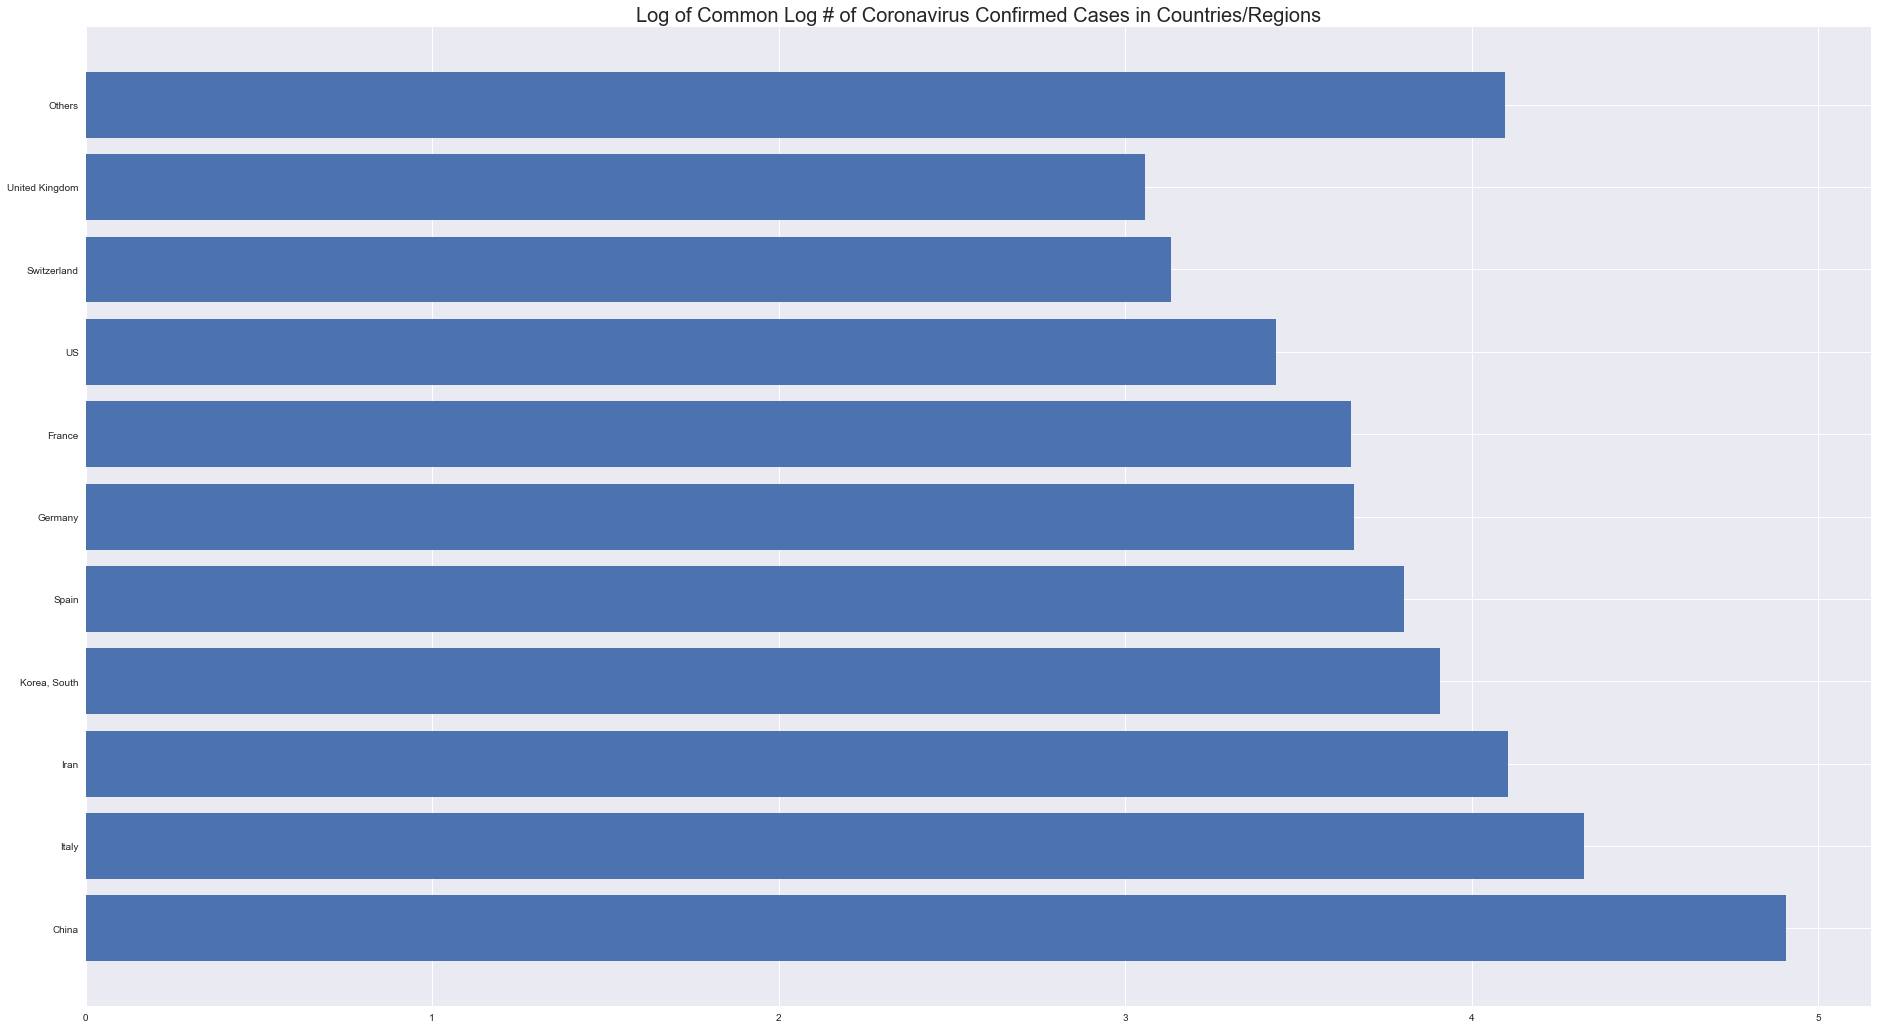

In [173]:
# lets look at it in a logarithmic scale 
log_country_confirmed_cases = [math.log10(i) for i in visual_confirmed_cases]
plt.figure(figsize=(32, 18))
plt.barh(visual_unique_countries, log_country_confirmed_cases)
plt.title('Log of Common Log # of Coronavirus Confirmed Cases in Countries/Regions', size=20)
plt.show()

In [174]:
# Only show 10 provinces with the most confirmed cases, the rest are grouped into the other category
visual_unique_provinces = [] 
visual_confirmed_cases2 = []
others = np.sum(province_confirmed_cases[10:])
for i in range(len(province_confirmed_cases[:10])):
    visual_unique_provinces.append(unique_provinces[i])
    visual_confirmed_cases2.append(province_confirmed_cases[i])

visual_unique_provinces.append('Others')
visual_confirmed_cases2.append(others)

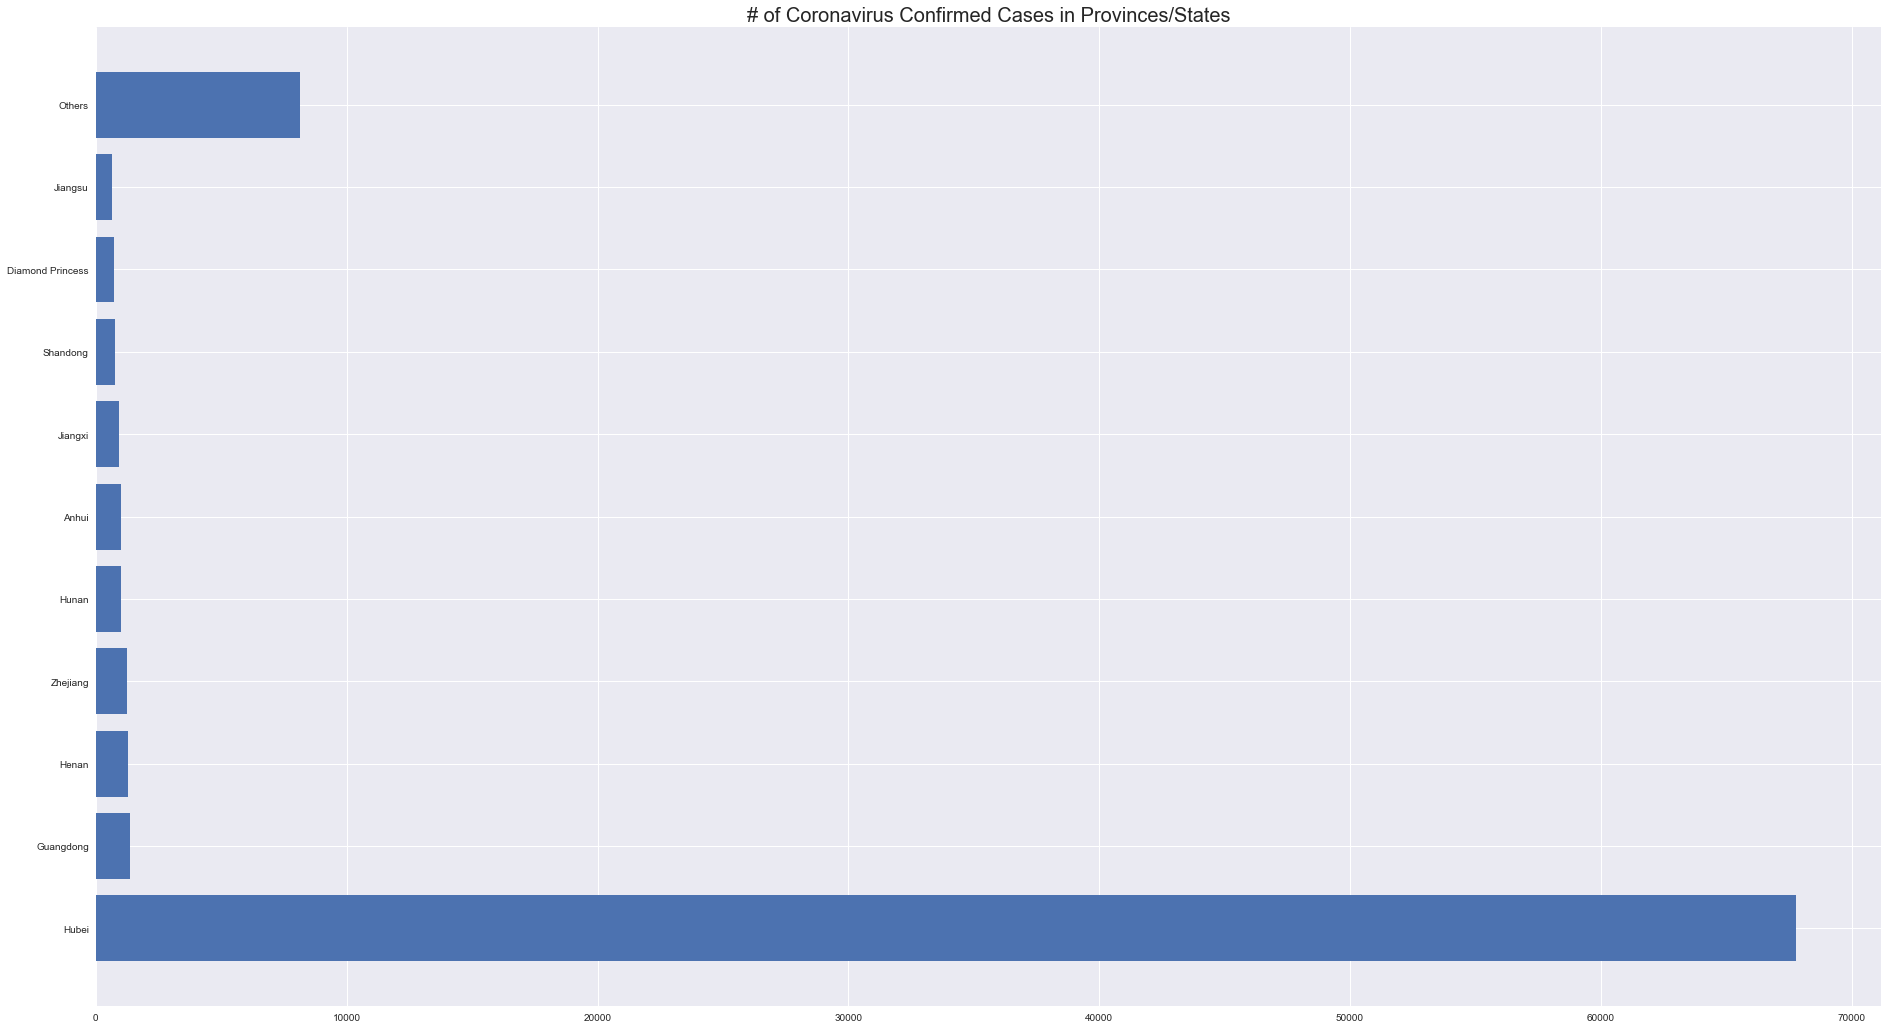

In [175]:
plt.figure(figsize=(32, 18))
plt.barh(visual_unique_provinces, visual_confirmed_cases2)
plt.title('# of Coronavirus Confirmed Cases in Provinces/States', size=20)
plt.show()

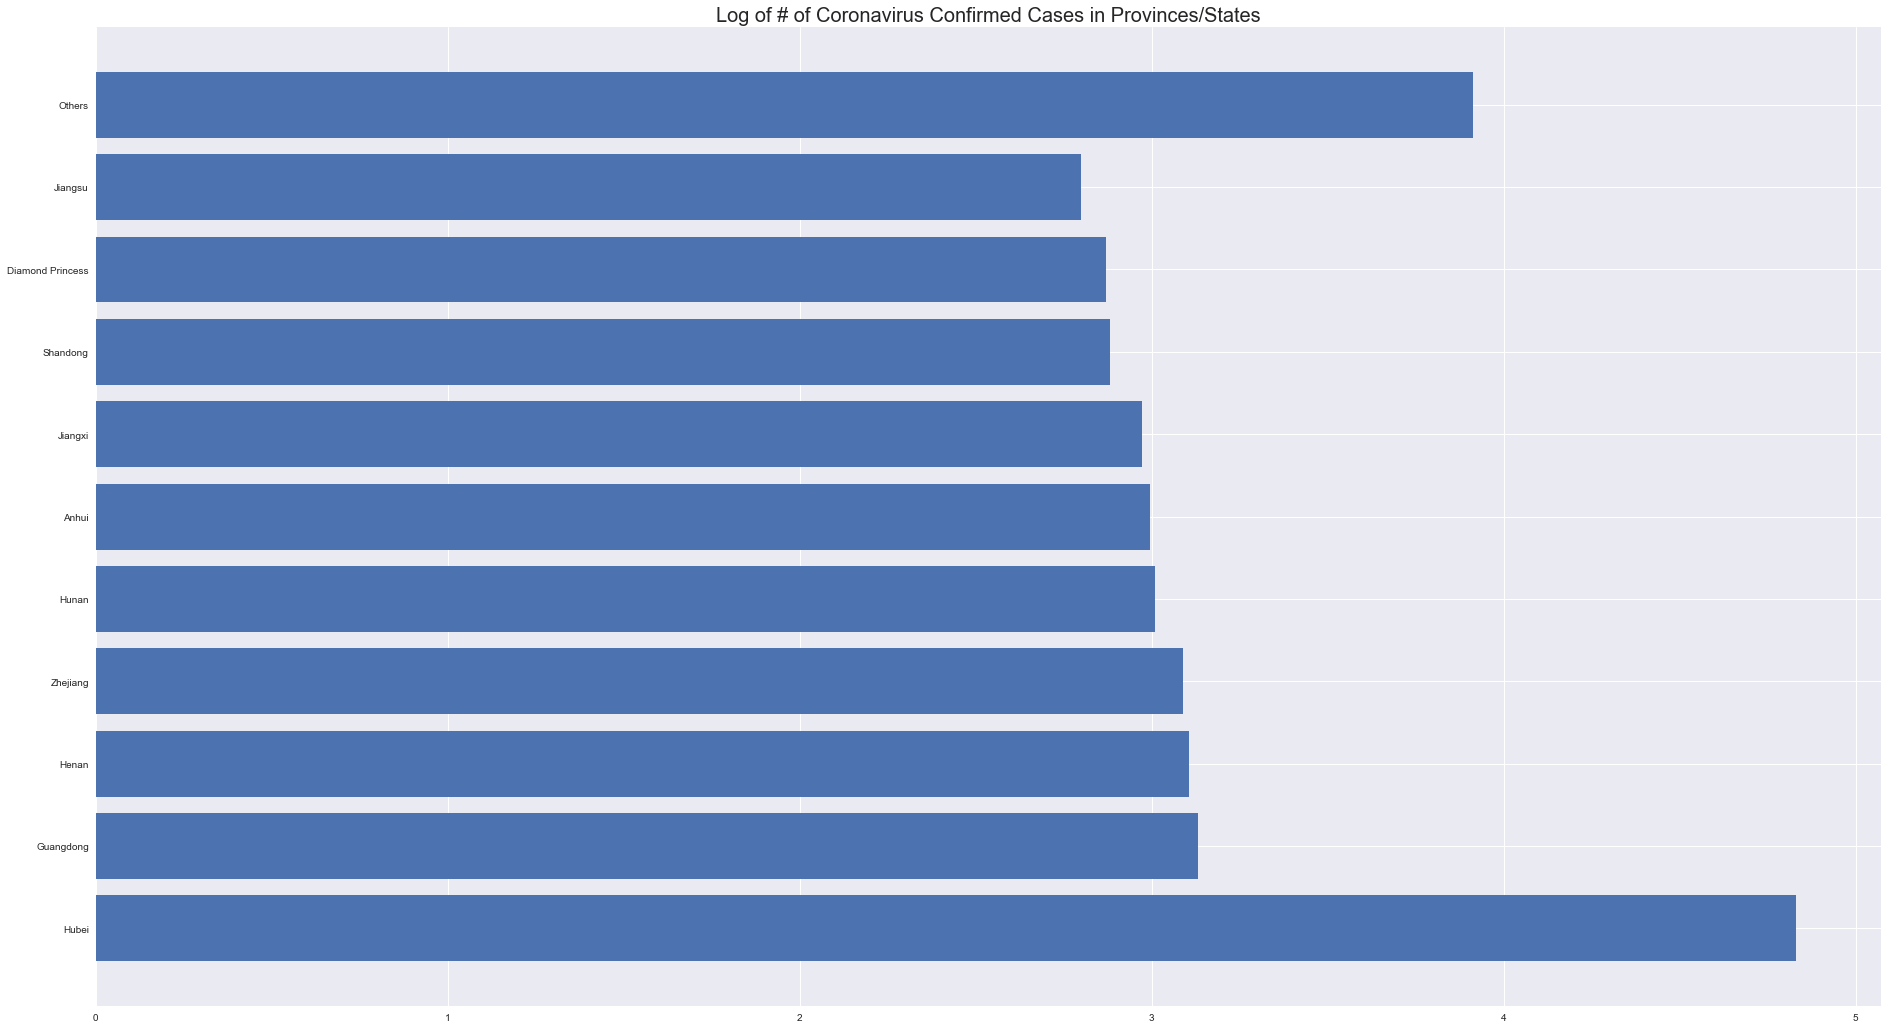

In [176]:
log_province_confirmed_cases = [math.log10(i) for i in visual_confirmed_cases2]
plt.figure(figsize=(32, 18))
plt.barh(visual_unique_provinces, log_province_confirmed_cases)
plt.title('Log of # of Coronavirus Confirmed Cases in Provinces/States', size=20)
plt.show()

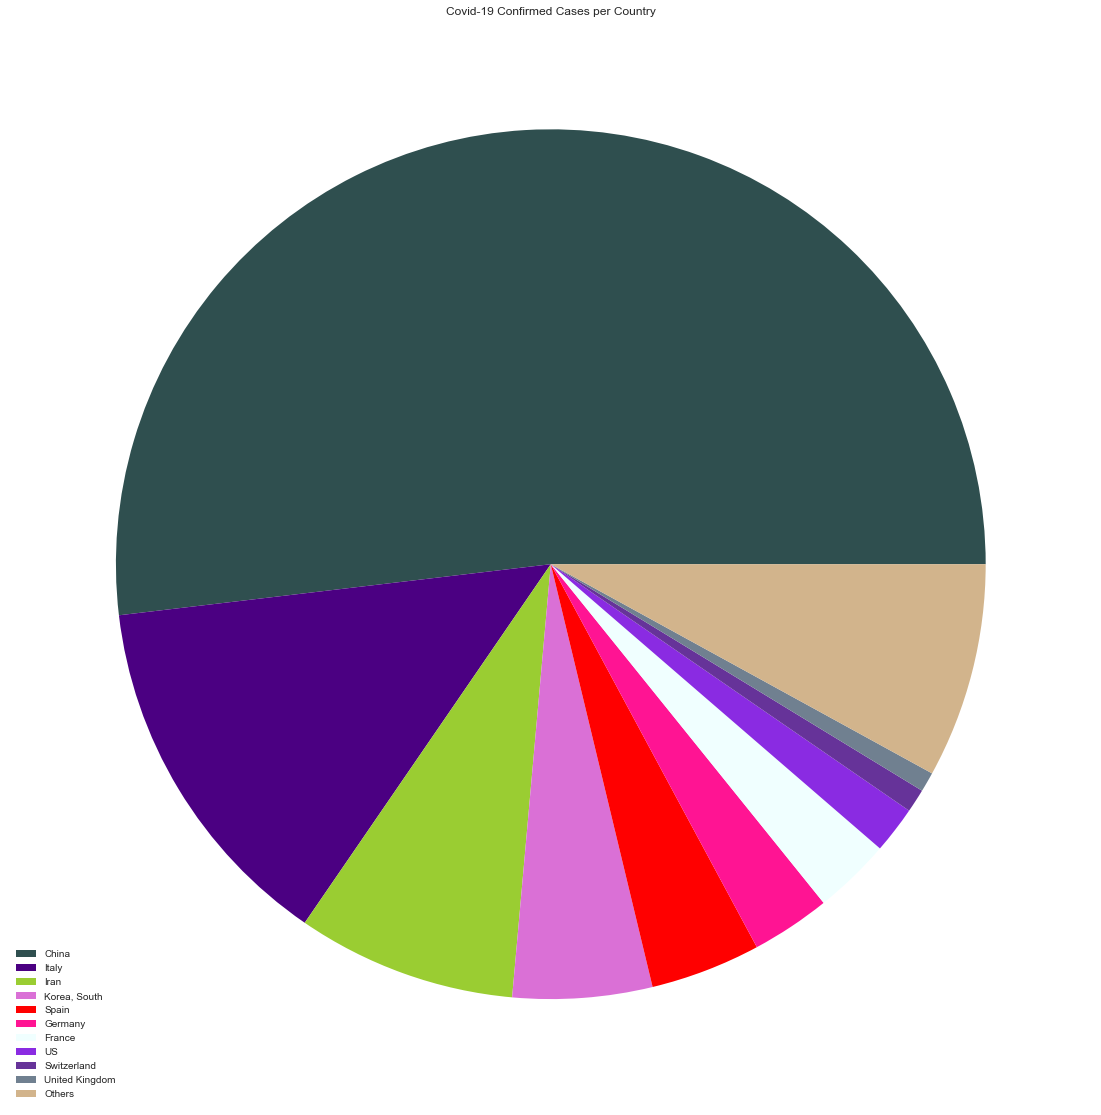

In [178]:
c = random.choices(list(mcolors.CSS4_COLORS.values()),k = len(unique_countries))
plt.figure(figsize=(20,20))
plt.title('Covid-19 Confirmed Cases per Country')
plt.pie(visual_confirmed_cases, colors=c)
plt.legend(visual_unique_countries, loc='best')
plt.show()

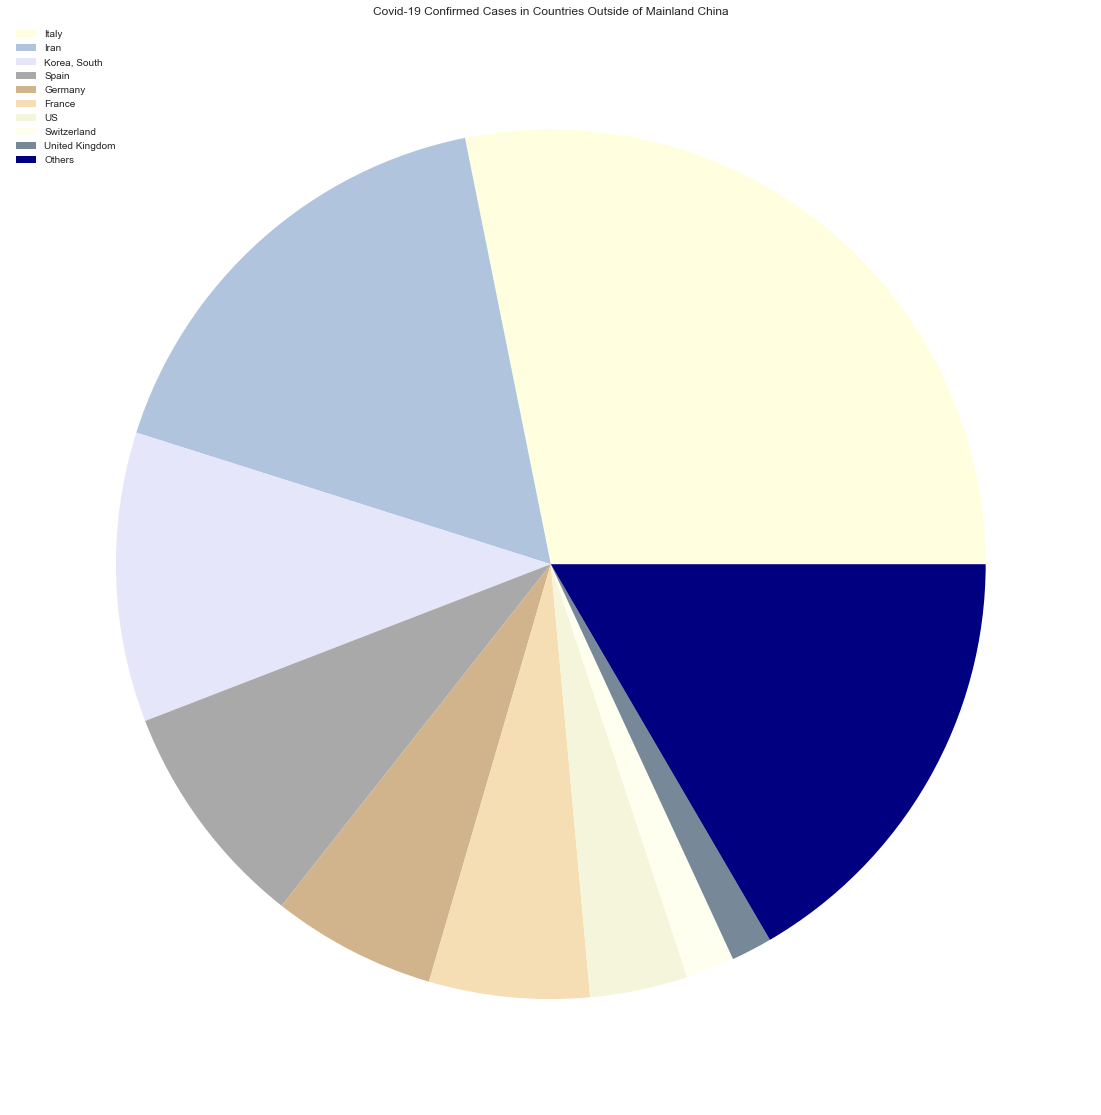

In [179]:
c = random.choices(list(mcolors.CSS4_COLORS.values()),k = len(unique_countries))
plt.figure(figsize=(20,20))
plt.title('Covid-19 Confirmed Cases in Countries Outside of Mainland China')
plt.pie(visual_confirmed_cases[1:], colors=c)
plt.legend(visual_unique_countries[1:], loc='best')
plt.show()

In [180]:
us_regions = list(confirmed_df[confirmed_df['Country/Region']=='US']['Province/State'].unique())
us_confirmed_cases = []
no_cases = [] 
for i in us_regions:
    cases = latest_confirmed[confirmed_df['Province/State']==i].sum()
    if cases > 0:
        us_confirmed_cases.append(cases)
    else:
        no_cases.append(i)
 
# remove areas with no confirmed cases
for i in no_cases:
    us_regions.remove(i)

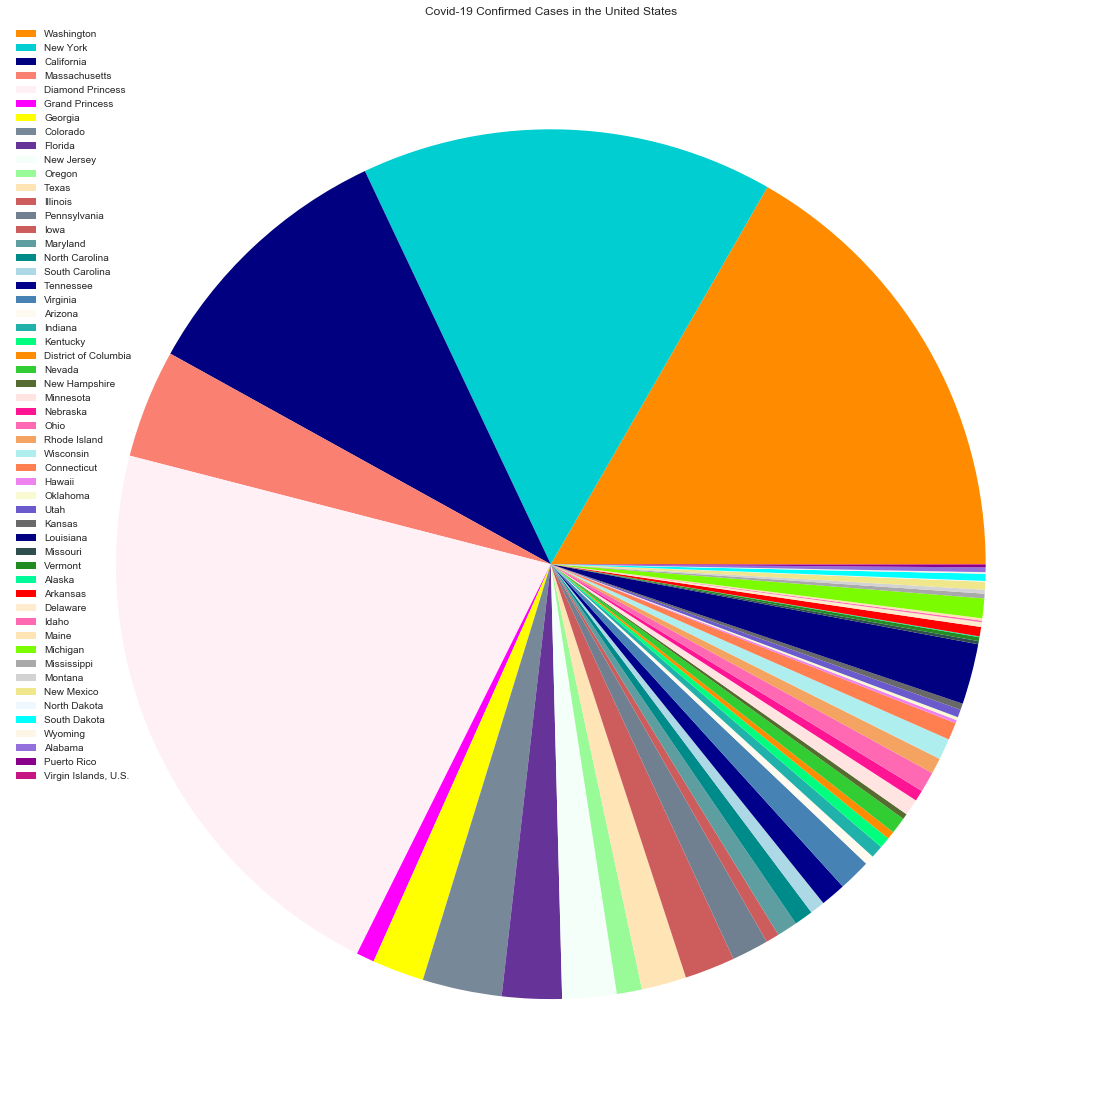

In [181]:
c = random.choices(list(mcolors.CSS4_COLORS.values()),k = len(unique_countries))
plt.figure(figsize=(20,20))
plt.title('Covid-19 Confirmed Cases in the United States')
plt.pie(us_confirmed_cases, colors=c)
plt.legend(us_regions, loc='best')
plt.show()